## EEG Seizure Clasficiation using 1D CNN
This project uses the **BONN EEG Dataset** to train a **1D convolution neural network (CNN)** to distinguish **seizure vs non seizure EEG segments**. 
The Bonn dataset contains EEG recordings from healthy volunteers and epilepsy patients, with segments labeled as seizure (ictal) or non-seizure (interictal/healthy). The goal is to demonstrate a deep learning approach for automated seizure detection from single-channel EEG data.


## Dataset

**Bonn EEG dataset** contains **five sets (A–E)**, each with 100 single-channel EEG segments (~23.6 seconds each, 4097 samples per segment, 173.61 Hz sampling rate).  

| Set | Description | Seizure? |
|-----|------------|-----------|
| A   | Healthy, eyes open | No |
| B   | Healthy, eyes closed | No |
| C   | Interictal, non-epileptogenic | No |
| D   | Interictal, epileptogenic | No |
| E   | Seizure (ictal) | Yes |


Links:
- [Bonn EEG Dataset](https://www.upf.edu/web/ntsa/downloads/-/asset_publisher/xvT6E4pczrBw/content/2001-indications-of-nonlinear-deterministic-and-finite-dimensional-structures-in-time-series-of-brain-electrical-activity-dependence-on-recording-regi)
- [Original Paper: Andrzejak et al., 2001](https://www.upf.edu/documents/229517819/232450661/Andrzejak-PhysicalReviewE2001.pdf/0e9a54b8-8993-b400-743e-4d64fa29fb63)


## Goals

1. Load and preprocess EEG segments from all sets.  
2. Normalize and filter EEG signals.  
3. Prepare training and test datasets.  
4. Build and train a **1D CNN** to classify seizure vs non-seizure segments.  
5. Evaluate model performance using accuracy, F1-score, and confusion matrix.  
6. Visualize example EEG segments and model predictions.


In [59]:
import os
import numpy as np
from scipy.signal import butter, filtfilt
import sys
import importlib
sys.path.append(os.path.abspath(".."))
from scripts.preprocess import load_and_preprocess
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scripts.utils import plot_eeg_segment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
from scripts.models import simple_EEG_MLP

## Load and Preprocess Data

In [61]:
## Load and preprocess data
base_path = os.path.abspath("../data")

# 0:non-seizure, 1: seizure 
folders = {
    "A": 0,
    "B": 0,
    "C": 0,
    "D": 0, 
    "E": 1
}

X, y = load_and_preprocess(base_path, folders)

X = np.array(X) 
print("EEG segments shape:", X.shape) # 500, 4097
y = np.array(y)
print("Labels shape:", y.shape)


# X: shape (500, 4097), y: labels (0/1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


EEG segments shape: (500, 4097)
Labels shape: (500,)
Train shape: (400, 4097)
Test shape: (100, 4097)


## Visualise EEG Segments and Normalisation

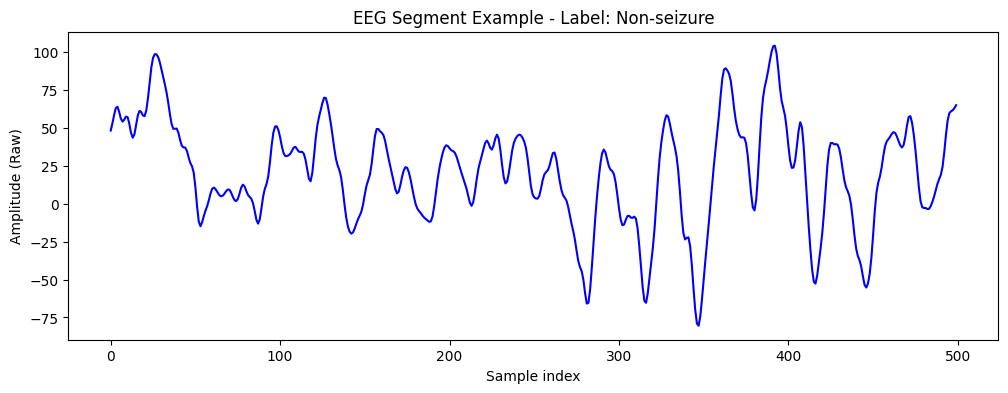

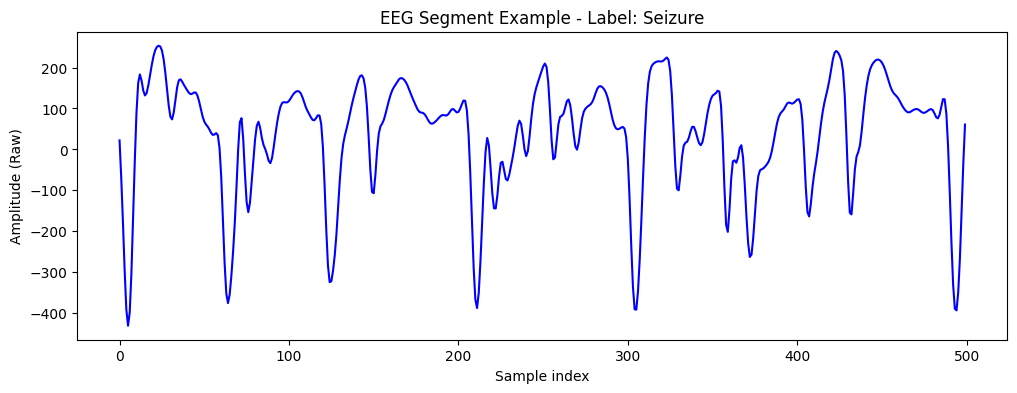

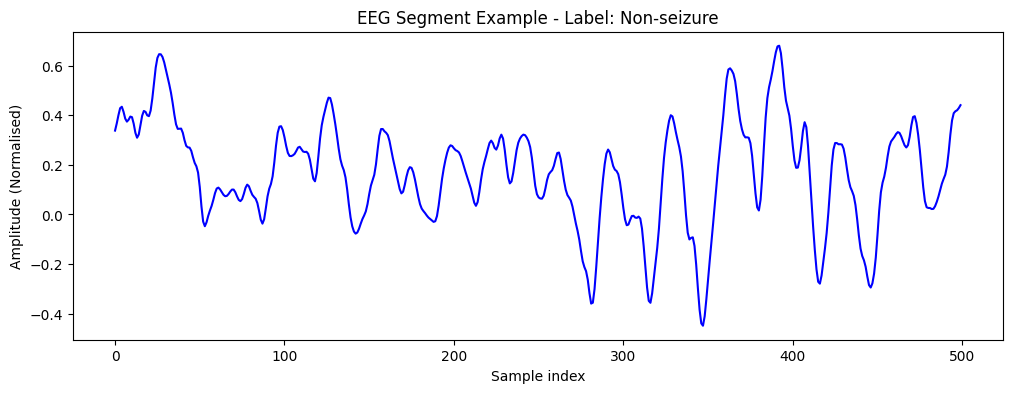

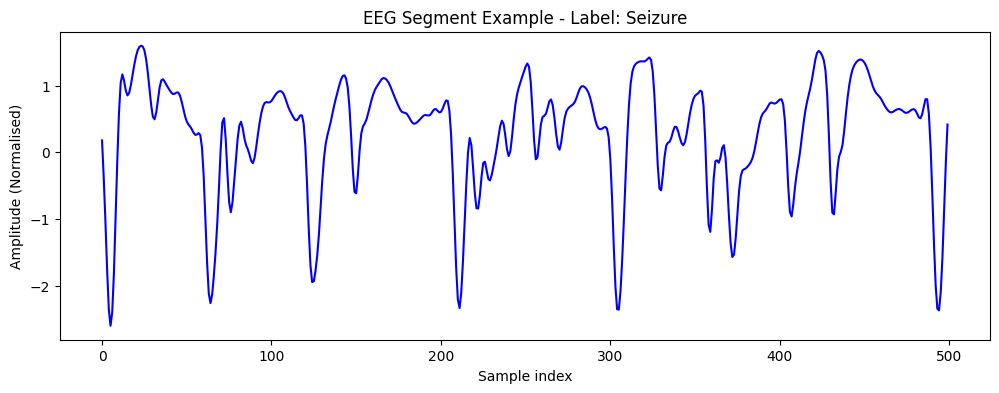

In [62]:
import importlib
import scripts.utils  # make sure you import the module itself, not just the function
importlib.reload(scripts.utils)  # reload the entire module
from scripts.utils import plot_eeg_segment

# Raw EEG segments visualisation
segment = X_train[0]  # Non-seizure
label = y_train[0]    # 0 = non-seizure, 1 = seizure
plot_eeg_segment(segment, label, norm= False)

# Seizure example
segment = X_train[1]  
label = y_train[1]    
plot_eeg_segment(segment, label, norm= False)

# Normalise data
from scripts.preprocess import normalise_segments
X_train_normalised, X_test_normalised = normalise_segments(X_train, X_test)

# Visualise non-seizure normalised
segment = X_train_normalised[0]  # shape: (4097,)
label = y_train[0]    # 0 = non-seizure, 1 = seizure
plot_eeg_segment(segment, label, norm= True)


# Visualise seizure normalised
segment = X_train_normalised[1]  # shape: (4097,)
label = y_train[1]    # 0 = non-seizure, 1 = seizure
plot_eeg_segment(segment, label, norm= True)

## Simple Multi-Layer Perceptron: Baseline Model
**Overview:**
The Multi-Layer Perceptron (MLP) is a fully connected neural network where each input feature is connected to every neuron in the next layer. For EEG classification, the MLP treats the signal as a flat vector of values, without explicitly considering the order or temporal relationships of the data points.

**Pros:**
- Simple architecture: easy to implement and train
- Baseline performance: provides reference point to compare more complex CNN models
- Fewer hyperparameters

**Cons:**
- Ignores temporal structures: doesn't consider the local patterns of EEG
- Overfitting risk: fully connected layers can have many parameters relative to number of samples

**Motivation:**
By first training an MLP model, we can measure how much improvement is gained by 1D CNN models, which can detect temporal patterns and allows us to test pre-processing, training and evaluation pipelines on a simpler model before advancing to more complex models. 


In [ ]:
# Convert NumPy arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)  # (n_samples, 1, 4097)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_ds = TensorDataset(X_train_torch, y_train_torch)
test_ds = TensorDataset(X_test_torch, y_test_torch)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)


In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = simple_EEG_MLP().to(device)
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3) # define optimisation algorithm

epochs = 10 # train the model for 10 full passes

# train and evaluate each epoch
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 8.0585, Train Acc: 0.6825 | Val Loss: 5.5332, Val Acc: 0.6700
Epoch 2/10 | Train Loss: 1.9662, Train Acc: 0.8225 | Val Loss: 3.0938, Val Acc: 0.8200
Epoch 3/10 | Train Loss: 1.2288, Train Acc: 0.9275 | Val Loss: 2.1721, Val Acc: 0.8200
Epoch 4/10 | Train Loss: 0.5175, Train Acc: 0.9550 | Val Loss: 1.4969, Val Acc: 0.8500
Epoch 5/10 | Train Loss: 0.7233, Train Acc: 0.9525 | Val Loss: 1.6555, Val Acc: 0.8700
Epoch 6/10 | Train Loss: 0.1550, Train Acc: 0.9700 | Val Loss: 1.6017, Val Acc: 0.8700
Epoch 7/10 | Train Loss: 0.7981, Train Acc: 0.9750 | Val Loss: 1.0207, Val Acc: 0.9100
Epoch 8/10 | Train Loss: 0.0743, Train Acc: 0.9875 | Val Loss: 0.7846, Val Acc: 0.9100
Epoch 9/10 | Train Loss: 0.0987, Train Acc: 0.9900 | Val Loss: 0.6931, Val Acc: 0.9400
Epoch 10/10 | Train Loss: 0.4062, Train Acc: 0.9850 | Val Loss: 0.6752, Val Acc: 0.8900
